In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [4]:
train_label_obj = np.load(f"../AUROCscore/labels/brand1/train_labels.npy",allow_pickle=True).item()
test_label_obj = np.load(f"../AUROCscore/labels/brand1/labels.npy",allow_pickle=True).item()
train_scores = np.load(f"../AUROCscore/scores/brand1/tranad_epoch5_lr1e-3/train_scores.npy",allow_pickle=True).item()
test_scores = np.load(f"../AUROCscore/scores/brand1/tranad_epoch5_lr1e-3/test_scores.npy",allow_pickle=True).item()

In [43]:
def flatten_scores(x):
    """x가 scalar/list/np.array 어떤 형태든 1D np.array로 변환"""
    if x is None:
        return np.array([])
    arr = np.asarray(x)
    return arr.reshape(-1)

def car_score(scores, k=3):
    s = np.sort(np.asarray(scores).reshape(-1))
    return s[-k:].mean()

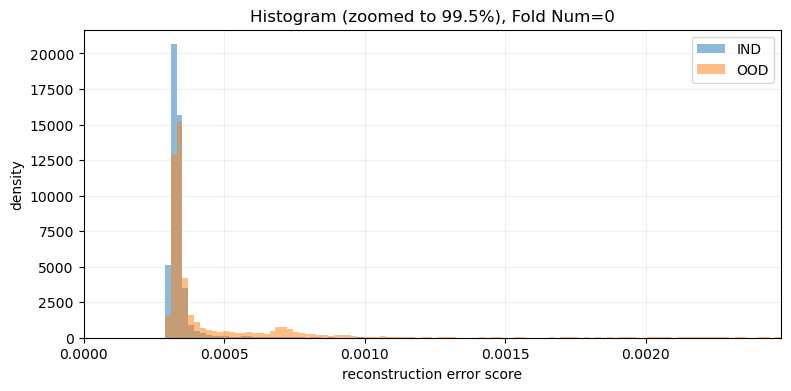

FN cars list :[171, 184, 105] 
TP cars list :[169, 174, 49, 181, 182, 183, 185, 186, 190, 191, 192, 194, 68, 197, 196, 78, 91, 98, 107, 108, 119] 


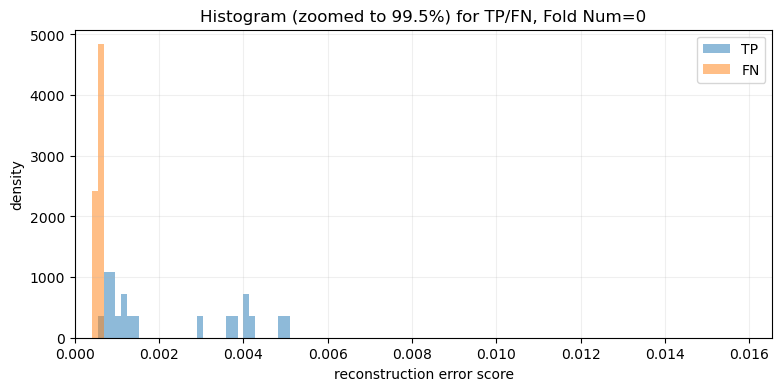

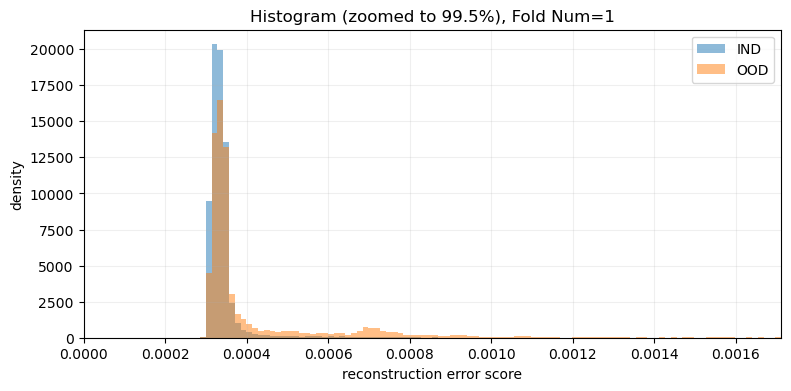

FN cars list :[21, 184, 196, 105, 119] 
TP cars list :[130, 136, 140, 150, 183, 157, 185, 186, 190, 191, 192, 194, 78, 68, 91, 197, 98, 107, 108] 


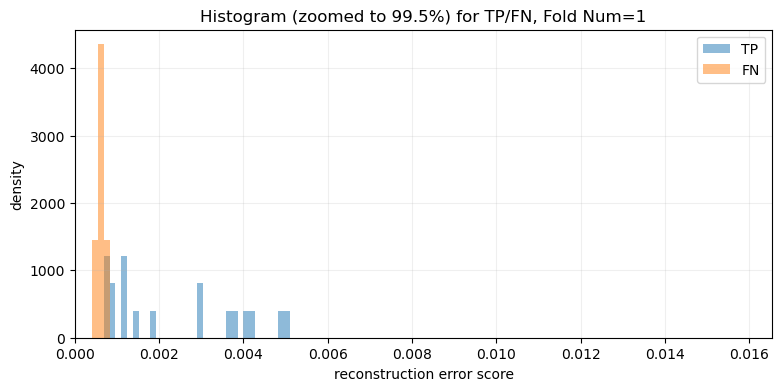

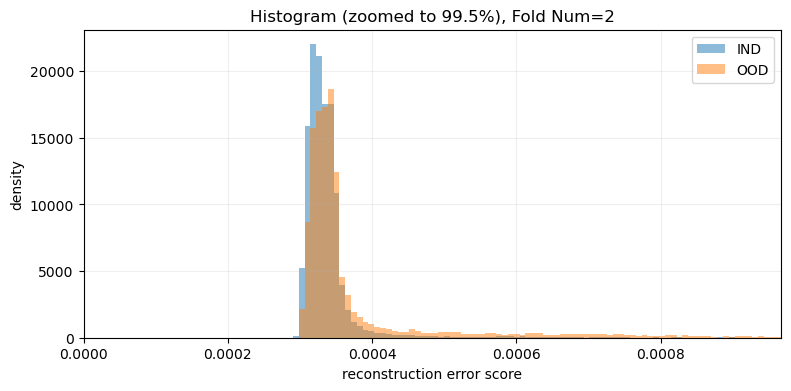

FN cars list :[21, 171, 196, 105] 
TP cars list :[130, 136, 140, 150, 157, 169, 174, 49, 181, 182, 192, 194, 68, 197, 78, 91, 98, 107, 108, 119] 


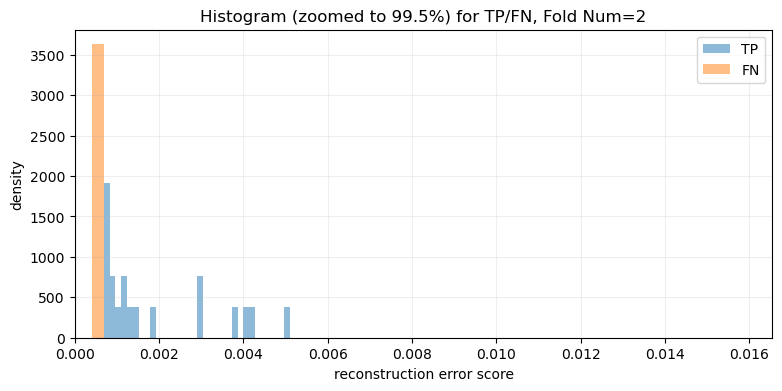

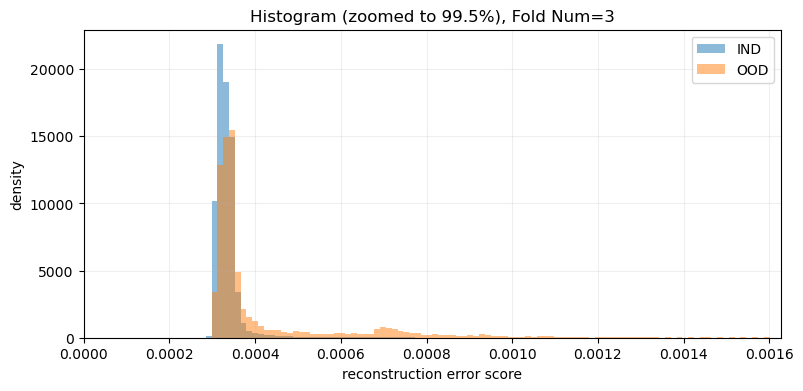

FN cars list :[21, 171, 184, 105, 119] 
TP cars list :[130, 136, 140, 150, 157, 169, 174, 49, 181, 182, 183, 185, 186, 190, 191, 91, 98, 107, 108] 


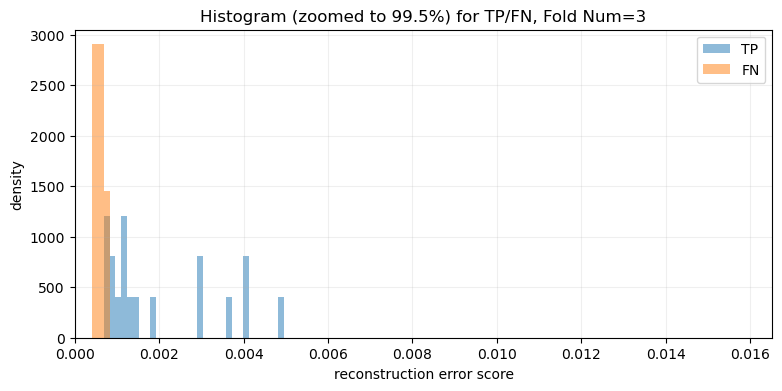

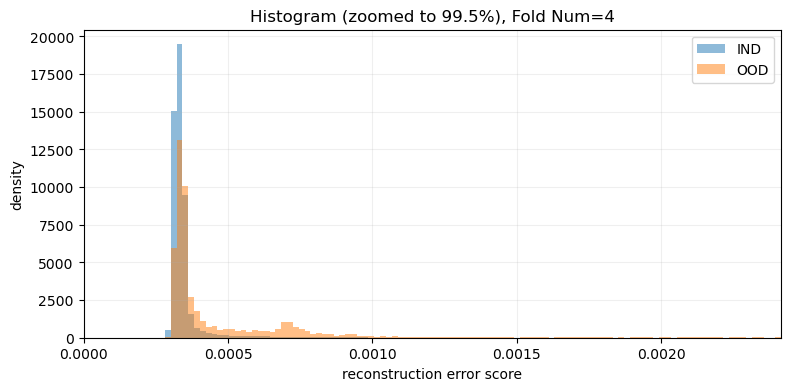

FN cars list :[21, 171, 184, 196] 
TP cars list :[130, 136, 140, 150, 157, 169, 174, 49, 181, 182, 183, 185, 186, 190, 191, 192, 194, 68, 197, 78] 


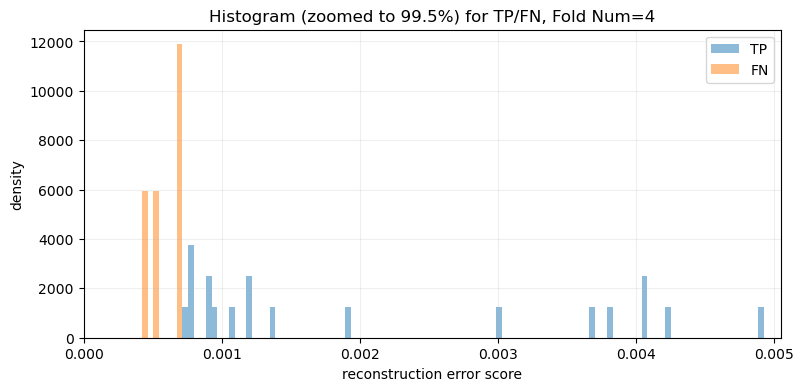

[171, 184, 105, 21, 184, 196, 105, 119, 21, 171, 196, 105, 21, 171, 184, 105, 119, 21, 171, 184, 196]


In [50]:
label_all = {}
label_all.update(train_label_obj)
label_all.update(test_label_obj)

ind_car_num_list = []
ood_car_num_list = []
for k,v in label_all.items():
    if v==1 :
        ood_car_num_list.append(k)
    elif v == 0:
        ind_car_num_list.append(k)

train_scores.update(test_scores)

Total_FN_cars = []

for i in range(5):
    fold_num = i

    test_car_list = ind_car_num_list[
        int(fold_num * len(ind_car_num_list) / 5) : int((fold_num + 1) * len(ind_car_num_list) / 5)
    ] + ood_car_num_list[: int(fold_num * len(ood_car_num_list) / 5)] \
      + ood_car_num_list[int((fold_num + 1) * len(ood_car_num_list) / 5) :]

    test_car_list = set(test_car_list)

    # --- fold의 test set에서 IND/OOD 점수 모으기 ---
    ind_scores = []
    ood_scores = []

    for cid in test_car_list:
        # label 가져오기 (1=abnormal, 0=normal)
        y = label_all.get(cid, None)
        if y is None:
            continue  # 라벨 없으면 스킵

        s = flatten_scores(train_scores.get(cid, None))
        if s.size == 0:
            continue

        if y == 1:
            ood_scores.append(s)
        else:
            ind_scores.append(s)

    ind_scores = np.concatenate(ind_scores) if len(ind_scores) else np.array([])
    ood_scores = np.concatenate(ood_scores) if len(ood_scores) else np.array([])

    # --- histogram plot ---
    x_all = np.concatenate([ind_scores, ood_scores])
    xmax = np.quantile(x_all, 0.995)  # 99.5%까지만 표시
    
    plt.figure(figsize=(9,4))
    bins = 120
    plt.hist(ind_scores, bins=bins, range=(0, xmax), density=True, alpha=0.5, label="IND")
    plt.hist(ood_scores, bins=bins, range=(0, xmax), density=True, alpha=0.5, label="OOD")
    plt.xlim(0, xmax)
    plt.title(f"Histogram (zoomed to 99.5%), Fold Num={fold_num}")
    plt.xlabel("reconstruction error score")
    plt.ylabel("density")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

    allcar_scores = {}
    for cid in test_car_list:
        allcar_scores[cid] = car_score(train_scores[cid])
    y_true = np.array([label_all[cid] for cid in test_car_list])
    y_score = np.array([allcar_scores[cid] for cid in test_car_list])
    
    fpr,tpr,thr = roc_curve(y_true,y_score)
    thr_tpr80 = thr[np.argmax(tpr>=0.8)]

    y_pred = (y_score > thr_tpr80).astype(int)

    FN_cars = [
        cid for cid,yt,yp in zip(test_car_list,y_true,y_pred)
        if yt==1 and yp==0
    ]
    TP_cars = [
        cid for cid in test_car_list
        if label_all[cid]==1 and allcar_scores[cid]>thr_tpr80
    ]
    print(f"FN cars list :{FN_cars} ")
    print(f"TP cars list :{TP_cars} ")
    for cid in FN_cars:
        Total_FN_cars.append(cid)
    TP_scores = [allcar_scores[cid] for cid in test_car_list
             if label_all[cid]==1 and allcar_scores[cid] > thr_tpr80]
    
    FN_scores = [allcar_scores[cid] for cid in FN_cars]

    x_all = np.concatenate([TP_scores, FN_scores])
    xmax = np.quantile(x_all, 0.995)  # 99.5%까지만 표시
    
    plt.figure(figsize=(9,4))
    bins = 120
    plt.hist(TP_scores, bins=bins, range=(0, xmax), density=True, alpha=0.5, label="TP")
    plt.hist(FN_scores, bins=bins, range=(0, xmax), density=True, alpha=0.5, label="FN")
    plt.xlim(0, xmax)
    plt.title(f"Histogram (zoomed to 99.5%) for TP/FN, Fold Num={fold_num}")
    plt.xlabel("reconstruction error score")
    plt.ylabel("density")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

print(Total_FN_cars)


In [51]:
from collections import Counter

In [ ]:
c = Counter(Total_FN_cars)
print(c)

Counter({171: 4, 184: 4, 105: 4, 21: 4, 196: 3, 119: 2})
